# CNN Demo program
## Use a kaggle playground project as example
#### by Sting Huang
### competition URL
### https://www.kaggle.com/c/plant-seedlings-classification

In [37]:
import tensorflow as tf
from tensorflow.python.framework import ops

print("\nTensorflow version:", tf.__version__)


Tensorflow version: 1.0.0-rc2


# Load data set
## train set has 4630 pictures
## validation set has 120 pictures
## the image was resize from original size to 128*128

In [2]:
from seedingimage import dataset  # user define class

train_db = dataset("train")
valid_db = dataset("validation")

1/12 dataset loaded
2/12 dataset loaded
3/12 dataset loaded
4/12 dataset loaded
5/12 dataset loaded
6/12 dataset loaded
7/12 dataset loaded
8/12 dataset loaded
9/12 dataset loaded
10/12 dataset loaded
11/12 dataset loaded
12/12 dataset loaded
{0: 'Fat Hen', 1: 'Charlock', 2: 'Common wheat', 3: 'Shepherds Purse', 4: 'Maize', 5: 'Scentless Mayweed', 6: 'Loose Silky-bent', 7: 'Common Chickweed', 8: 'Sugar beet', 9: 'Cleavers', 10: 'Small-flowered Cranesbill', 11: 'Black-grass'}
Total data set: 4630 (4630, 3)  time: 50.21069145202637
1/12 dataset loaded
2/12 dataset loaded
3/12 dataset loaded
4/12 dataset loaded
5/12 dataset loaded
6/12 dataset loaded
7/12 dataset loaded
8/12 dataset loaded
9/12 dataset loaded
10/12 dataset loaded
11/12 dataset loaded
12/12 dataset loaded
{0: 'Fat Hen', 1: 'Charlock', 2: 'Common wheat', 3: 'Shepherds Purse', 4: 'Maize', 5: 'Scentless Mayweed', 6: 'Loose Silky-bent', 7: 'Common Chickweed', 8: 'Sugar beet', 9: 'Cleavers', 10: 'Small-flowered Cranesbill', 11:

# Take a look on data

Maize  => [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


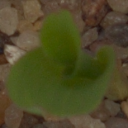

Loose Silky-bent  => [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


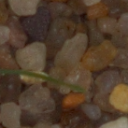

Scentless Mayweed  => [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


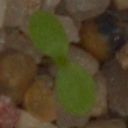

Charlock  => [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


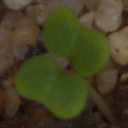

Charlock  => [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


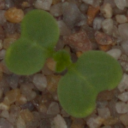

In [4]:
from IPython.core.display import display

images_np , labels, images = train_db.get_images(5)
for img, digitial in zip(images, labels):    
    print(train_db.mapLabel(digitial), " =>", digitial)
    display(img)

# Define Model

In [5]:
import numpy as np

from network import network # user define class

LR = 1e-4
CLASS_NUM = 12
IMG_H = 128
IMG_W = 128

class Model(network):
    def setup(self, autoencoder, name = None):
        assert  name != None
        self.padding = "SAME"
        with tf.variable_scope(name):
            self.image = tf.placeholder(tf.float32, [None, IMG_H,IMG_W, 3], name="image")
            if self.trainable == True: # for test and validation
                self.keep_prob = tf.placeholder(tf.float32)
                self.y_ = tf.placeholder(tf.float32, [None, CLASS_NUM], name="labels")
            (self.feed(self.image )
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con1")  #128*128*3 -> 128*128*16
                .conv2d(mask = [3,3], out_channel = 16, strides = [1,1], name = "l1con2")  #128*128*16 -> 128*128*16
                .max_pool(mask = [2,2])  #128*128*16 -> 64*64*16
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con1")  #64*64*16 -> 64*64*32
                .conv2d(mask = [3,3], out_channel = 32, strides = [1,1], name = "l2con2")  #64*64*32 -> 64*64*32
                .max_pool(mask = [2,2])  #64*64*32 -> 32*32*32
                .conv2d(mask = [3,3], out_channel = 64, strides = [1,1], name = "l3con1")  #32*32*32 -> 32*32*64
                .makeflat() # 32*32864 -> 65536
                .dropout(keep_prob = self.keep_prob)
                .fc(512, relu = True, trainable = self.trainable, name = "fc1")
                .dropout(keep_prob = self.keep_prob)
                .fc(256, relu = True, trainable = self.trainable, name = "fc2")
                .dropout(keep_prob = self.keep_prob)
                .fc(CLASS_NUM, relu = False, trainable = self.trainable, name = "out")
            )

            self.y = self.get_ouput()
            print( self.y, np.shape(self.y_))
            self.predict_soft =  tf.nn.softmax(self.y, name = "soft")
            self.predict = tf.argmax(self.y, axis = 1, name = "predict")
            if self.trainable == True: # for test and validation
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( labels = self.y_, logits = self.y,  name='loss_'), name = "loss")
                correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
                self.accuracy= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                self.trainStep =  tf.train.AdamOptimizer(LR, name = "train_opt").minimize(self.cost)

# Train Model

In [6]:
ops.reset_default_graph()  #< ==== reset everything
net = Model(name= "CNN")
SAVE = "save/cnn.ckpt"
KEEP_PROB = 0.5
echo = 0
patient = 15
best_acc = 0
best_valid_acc = 0
best_step = 0
saver = tf.train.Saver()
training_process = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
while(True):
    echo += 1
    x_, y_ = train_db.get_batch(32)
    feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: KEEP_PROB}
    sess.run(net.trainStep, feed_dict = feed_dict)
    if echo % 50 == 0:
        x_, y_ = train_db.get_batch(64)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        cost, acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        x_, y_ = valid_db.get_batch(120)
        feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
        valid_cost, valid_acc = sess.run( (net.cost, net.accuracy), feed_dict = feed_dict)
        print("Step:{0}, training cost:{1:.3f}, accuracy:{2:.3f}, validation cost:{3:.3f}, accuracy:{4:.3f}".format( echo, cost, acc, valid_cost,valid_acc))
        training_process.append([acc, valid_acc])
        patient -= 1
        if best_acc < acc:
            best_acc = acc
            best_valid_acc = valid_acc
            patient = 10
            best_step = echo
            print(saver.save(sess, SAVE, global_step = echo))
    if patient <= 0:
        print("Early stop on step {0} with accuracy:{1:.3f} and validation accuracy:{2:.3f}".format( best_step, best_acc, best_valid_acc))
        break

Tensor("CNN/out/CNN/out:0", shape=(?, 12), dtype=float32) (?, 12)
Step:50, training cost:2.457, accuracy:0.078, validation cost:2.548, accuracy:0.083
save/cnn.ckpt-50
Step:100, training cost:2.506, accuracy:0.125, validation cost:2.532, accuracy:0.083
save/cnn.ckpt-100
Step:150, training cost:2.392, accuracy:0.219, validation cost:2.555, accuracy:0.158
save/cnn.ckpt-150
Step:200, training cost:1.973, accuracy:0.359, validation cost:2.239, accuracy:0.242
save/cnn.ckpt-200
Step:250, training cost:1.746, accuracy:0.375, validation cost:1.890, accuracy:0.300
save/cnn.ckpt-250
Step:300, training cost:1.373, accuracy:0.531, validation cost:1.746, accuracy:0.342
save/cnn.ckpt-300
Step:350, training cost:1.253, accuracy:0.656, validation cost:1.611, accuracy:0.383
save/cnn.ckpt-350
Step:400, training cost:1.427, accuracy:0.484, validation cost:1.540, accuracy:0.450
Step:450, training cost:1.149, accuracy:0.609, validation cost:1.439, accuracy:0.458
Step:500, training cost:1.281, accuracy:0.531

# Plot the traninig process

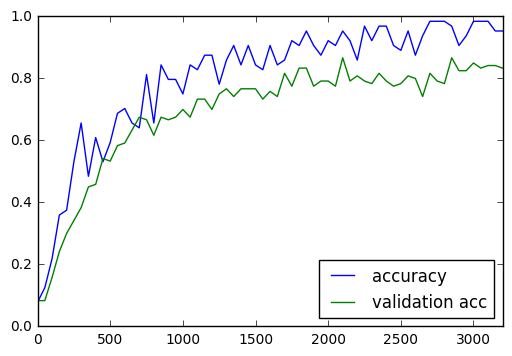

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(training_process,index=np.arange(len(training_process)*50, step =50), columns =['accuracy','validation acc'])
data.plot()
plt.show()

# Check result

Successfully loaded: save/cnn.ckpt-2750
actually => predict result: Cleavers  =>  Cleavers


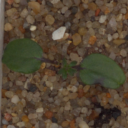

actually => predict result: Loose Silky-bent  =>  Loose Silky-bent


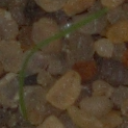

actually => predict result: Shepherds Purse  =>  Shepherds Purse


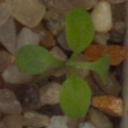

actually => predict result: Maize  =>  Maize


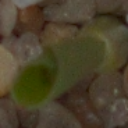

actually => predict result: Fat Hen  =>  Fat Hen


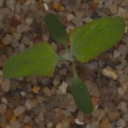

In [11]:
net.loadsavedstate(sess, None)
x_, y_, images = valid_db.get_images(5)
feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
predict = sess.run( (net.predict), feed_dict = feed_dict)
for img, digitial_, digitial in zip(images, y_, predict):
    label_oh = np.zeros((CLASS_NUM,))
    label_oh[digitial] = 1
    print( "actually => predict result:", train_db.mapLabel(digitial_), " => ", train_db.mapLabel(label_oh))
    display(img)    

# Take a look on feature map
## Side by side compares the feature map between difference image

source image


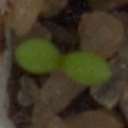

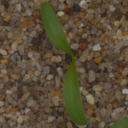

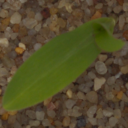

feature map of l1con0


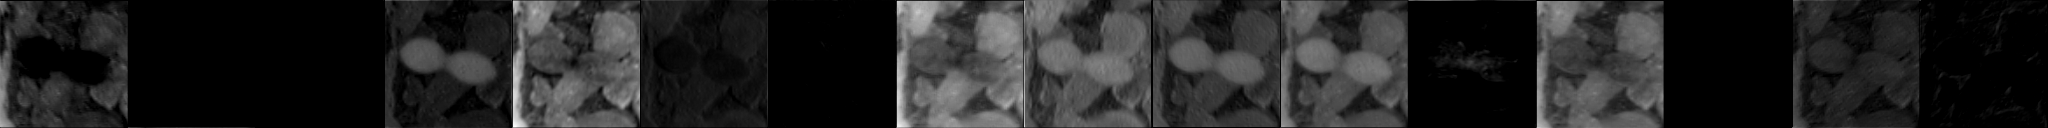

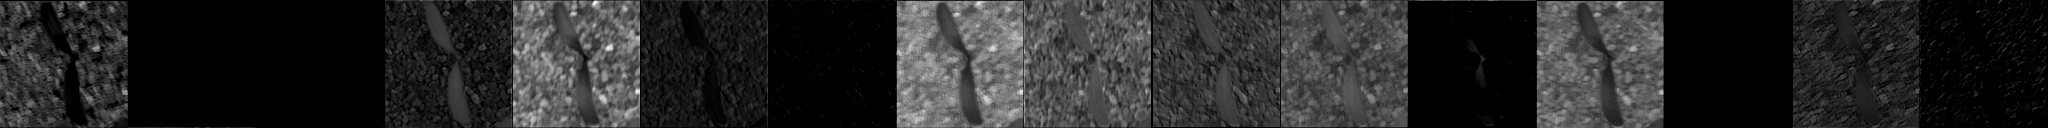

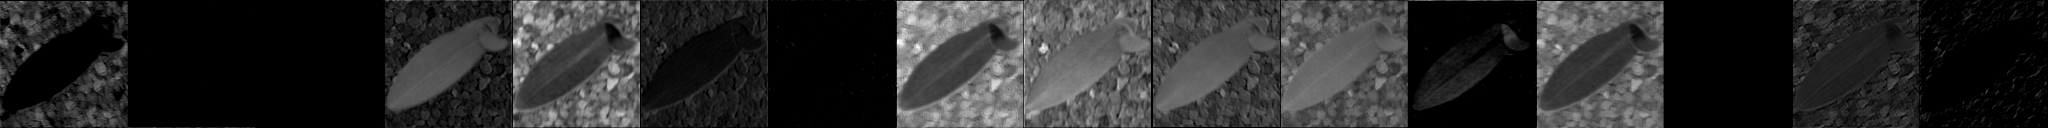

feature map of l2con0


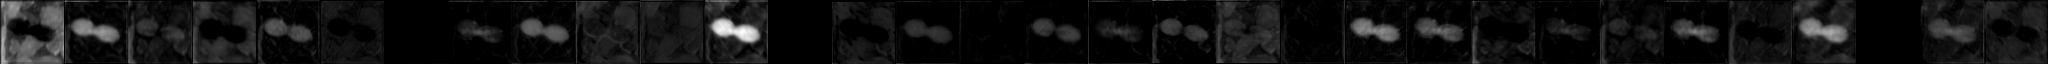

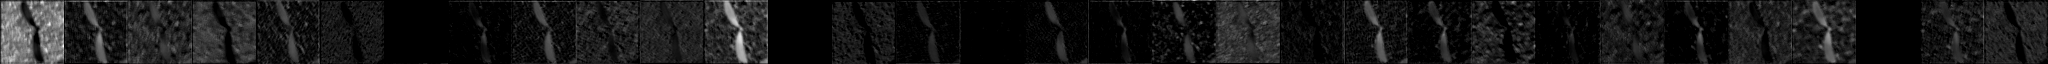

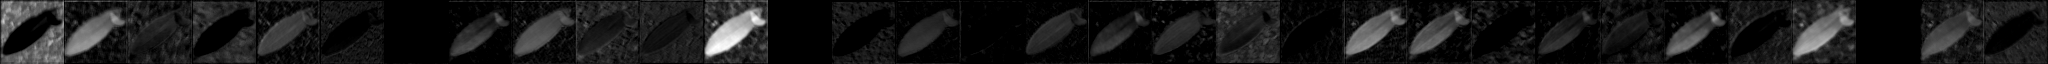

feature map of l3con0


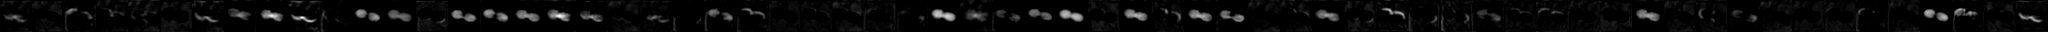

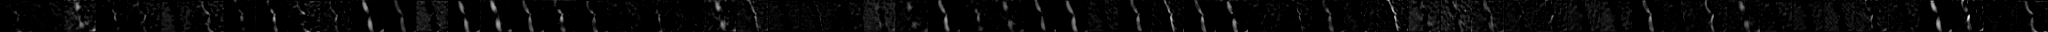

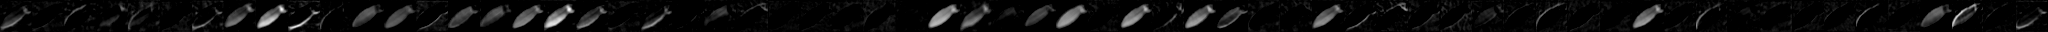

In [41]:
from scipy.misc.pilutil import toimage

x_, y_, images = valid_db.get_images(3)
feed_dict = {net.image: x_, net.y_: y_, net.keep_prob: 1}
l1con0, l2con0, l3con0 = sess.run( (net.feedlayer[-14], net.feedlayer[-11], net.feedlayer[-8]), feed_dict = feed_dict)

print("source image")
for img in images:
    display(img)

print("feature map of l1con0")
for img_idx in range(3):
    l1 = l1con0[img_idx,:,:,0]
    for layer in range(1,  np.shape(l1con0)[3]):
        l1 = np.concatenate((l1[:,:], l1con0[img_idx,:,:,layer]), axis = 1)
    display(toimage(l1))

print("feature map of l2con0")
for img_idx in range(3):
    l2 = l2con0[img_idx,:,:,0]
    for layer in range(1,  np.shape(l2con0)[3]):
        l2 = np.concatenate((l2[:,:], l2con0[img_idx,:,:,layer]), axis = 1)
    display(toimage(l2))    

print("feature map of l3con0")    
for img_idx in range(3):
    l3 = l3con0[img_idx,:,:,0]
    for layer in range(1,  np.shape(l3con0)[3]):
        l3 = np.concatenate((l3[:,:], l3con0[img_idx,:,:,layer]), axis = 1)
    display(toimage(l3))